In [1]:
# import libraries
import pandas as pd
import numpy as np
import math
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyoff
import plotly.figure_factory as ff
import datetime
from pandas import to_datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.api as smt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

from fbprophet import Prophet
from matplotlib import pyplot
from scipy.stats import boxcox

pio.renderers
pio.renderers.default='notebook+jupyterlab'
plotly.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/top_selling_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1740 entries, 0 to 1739
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1740 non-null   object 
 1   InvoiceNo    1740 non-null   int64  
 2   StockCode    1740 non-null   int64  
 3   Description  1740 non-null   object 
 4   Quantity     1740 non-null   int64  
 5   InvoiceDate  1740 non-null   object 
 6   UnitPrice    1740 non-null   float64
 7   CustomerID   1740 non-null   float64
 8   Country      1740 non-null   object 
 9   Year         1740 non-null   int64  
 10  Quarter      1740 non-null   int64  
 11  Month        1740 non-null   int64  
 12  Week         1740 non-null   int64  
 13  Day          1740 non-null   int64  
 14  Weekday      1740 non-null   int64  
 15  Total_Sales  1740 non-null   float64
dtypes: float64(3), int64(9), object(4)
memory usage: 217.6+ KB


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Quarter,Month,Week,Day,Weekday,Total_Sales
0,2011-05-10,552654,23084,RABBIT NIGHT LIGHT,2,2011-05-10 14:20:00,2.08,15756.0,United Kingdom,2011,2,5,19,10,1,4.16
1,2011-05-11,552724,23084,RABBIT NIGHT LIGHT,6,2011-05-11 10:29:00,2.08,13418.0,United Kingdom,2011,2,5,19,11,2,12.48
2,2011-05-11,552811,23084,RABBIT NIGHT LIGHT,24,2011-05-11 12:43:00,1.79,17677.0,United Kingdom,2011,2,5,19,11,2,42.96
3,2011-05-11,552816,23084,RABBIT NIGHT LIGHT,1,2011-05-11 12:47:00,2.08,15521.0,United Kingdom,2011,2,5,19,11,2,2.08
4,2011-05-11,552822,23084,RABBIT NIGHT LIGHT,30,2011-05-11 12:59:00,1.79,15521.0,United Kingdom,2011,2,5,19,11,2,53.70


In [4]:
df1 = df.loc[df['Description']=='POPCORN HOLDER']
df1 = df1.groupby(['Date'])['Quantity'].sum().reset_index()
df1 = df1[['Date', 'Quantity']]

In [5]:
df1.shape

(149, 2)

In [6]:
fig = go.Figure(data=[go.Scatter(x=df1.Date, y=df1.Quantity, line_color='darkturquoise')])
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Total Quantity", 
                  title='Daily Sales by Quantity',
                  height=400,
                 template='ggplot2')
fig.show()

## ARIMA

In [93]:
df1.set_index('Date', inplace = True)
df1.head()

,Quantity
Date,
2011-06-12,9
2011-06-13,15
2011-06-14,14
2011-06-15,103
2011-06-16,9


In [8]:
#Is the data stationary?
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df1)


(0.01, False)

In [9]:
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df1)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")

pvalue =  1.6080466923379071e-21  if above 0.05, data is not stationary


In [10]:
if pvalue > 0.05:
    print("Data is not stationary")
else:
    print("Data is stationary")

Data is stationary


In [36]:
from pmdarima.arima import auto_arima
# Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
# p, d, q represent non-seasonal components
# P, D, Q represent seasonal components

arima_model = auto_arima(df1['Quantity'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2160.757, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2083.966, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2133.579, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2083.552, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2080.553, Time=0.63 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=2079.284, Time=1.57 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=2080.061, Time=1.97 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.52 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=5.68 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=2125.562, Time=1.24 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=2060.947, Time=1.66 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=2

In [37]:
print(arima_model.summary() ) 

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  149
Model:             SARIMAX(4, 1, 1)x(4, 1, [], 12)   Log Likelihood               -1007.359
Date:                             Tue, 23 Mar 2021   AIC                           2034.718
Time:                                     21:08:10   BIC                           2063.844
Sample:                                          0   HQIC                          2046.554
                                             - 149                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1435      0.165     -0.871      0.384      -0.467       0.180
ar.L2         -0.1108      

In [69]:
#Split data into train and test
size = int(len(df1) * 0.66)
X_train, X_test = df1[0:size], df1[size:len(df1)]

In [70]:
# Fit a Model: SARIMAX(4, 1, 1)x(4, 1, [], 12) on training set
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['Quantity'],  
                order = (4, 1, 1),  
                seasonal_order =(4, 1, 0, 12))

In [71]:
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Quantity   No. Observations:                   98
Model:             SARIMAX(4, 1, 1)x(4, 1, [], 12)   Log Likelihood                -600.164
Date:                             Tue, 23 Mar 2021   AIC                           1220.328
Time:                                     22:07:00   BIC                           1244.755
Sample:                                          0   HQIC                          1230.153
                                              - 98                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0244      0.164      0.149      0.882      -0.297       0.346
ar.L2          0.0580      0.226      0.257      0.797      -0.385       0.501
ar.L3          0.0704      0.147      0.479      0.632      -0.217       0.358
ar.L4          0.1861      0.140      1.329      0.184      -0.088       0.461
ma.L1         -1.0000      0.136     -7.351      0.000      -1.267      -0.733
ar.S.L12      -0.8481      0.114     -7.461      0.000      -1.071      -0.625
ar.S.L24      -0.7612      0.132     -5.756      0.000      -1.020      -0.502
ar.S.L36      -0.7017      0.147     -4.759      0.000      -0.991      -0.413
ar.S.L48      -0.7331      0.057    -12.940      0.000      -0.844      -0.622
sigma2      4.606e+04   2.95e-06   1.56e+10      0.000    4.61e+04    4.61e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1248.22
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              14.95   Skew:                             3.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.23e+25. Standard errors may be unstable.
"""

In [72]:
#Train prediction
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

In [73]:
#Prediction
start_index = len(X_train)
end_index = len(df1)-1
prediction = result.predict(start_index, end_index).rename('Forecast') 

In [74]:
forecast_df = X_test.copy()
forecast_df['Forecast'] = prediction.values

<AxesSubplot:xlabel='Date'>

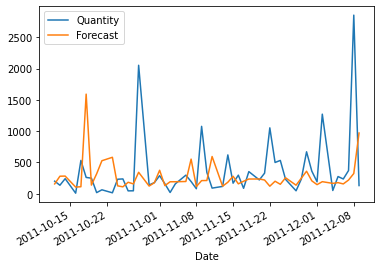

In [75]:
forecast_df.plot()

In [76]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 263.42 RMSE
Test Score: 571.62 RMSE


## Prophet

In [80]:
df1.reset_index(inplace = True)

In [81]:
df_split = df1[:100]

In [82]:
df1p = pd.DataFrame()
df1p['ds'] = df_split['Date']
df1p['y'] = df_split['Quantity']
df1p['ds']= to_datetime(df1p['ds'])

In [91]:
df1p.head()

,ds,y
0,2011-06-12,9
1,2011-06-13,15
2,2011-06-14,14
3,2011-06-15,103
4,2011-06-16,9


In [84]:
m = Prophet()
m.fit(df1p)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [85]:
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)

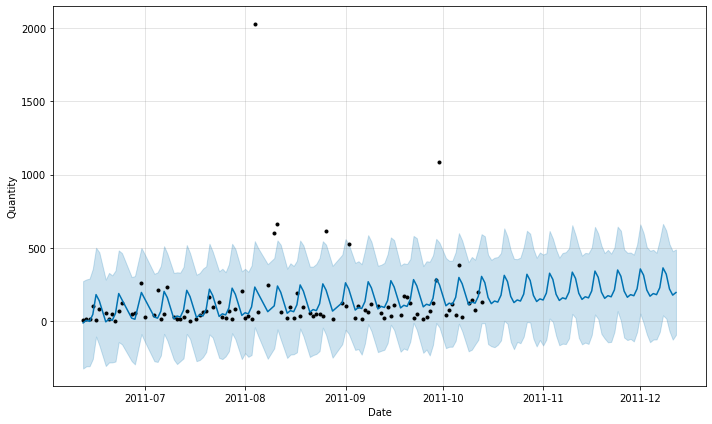

In [86]:
figure = m.plot(forecast, xlabel='Date', ylabel='Quantity')

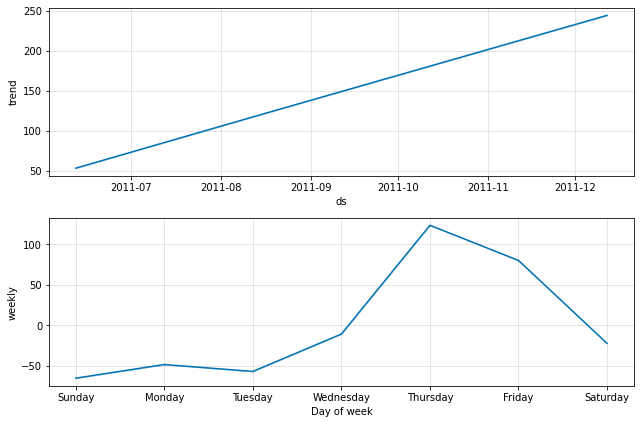

In [87]:
figure2 = m.plot_components(forecast)

In [90]:
# Evaluate the forecast accuracy / usability based on some predefined performance metrics
metric_df = forecast.set_index('ds')[['yhat']].join(df1p.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(f"r2_score = {r2_score(metric_df.y, metric_df.yhat)}")
print(f"MSE = {mean_squared_error(metric_df.y, metric_df.yhat)}")
print(f"MAE = {mean_absolute_error(metric_df.y, metric_df.yhat)}")
print(f'RMSE {math.sqrt(mean_squared_error(metric_df.y, metric_df.yhat))}')

r2_score = 0.09913514050892647
MSE = 55298.01973292838
MAE = 112.83489456796633
RMSE 235.15530981232038


## Vector Autoregression Model (VAR) for Multivariate TS

In a VAR model, each variable is a linear function of the past values of itself and the past values of all the other variables. 

Unlike AR, VAR is able to understand and use the relationship between several variables. This is useful for describing the dynamic behavior of the data and also provides better forecasting results.

The procedure to build a VAR model involves the following steps:

1. Analyze the time series characteristics
2. Test for causation amongst the time series
3. Test for stationarity
4. Transform the series to make it stationary, if needed
5. Find optimal order (p)
6. Prepare training and test datasets
7. Train the model
8. Roll back the transformations, if any.
9. Evaluate the model using test set
10. Forecast to future


In [139]:
from statsmodels.tsa.api import VAR

In [140]:
dfv = df.loc[df['Description']=='POPCORN HOLDER']

In [141]:
dfv = dfv[['Date', 'Quantity', 'Total_Sales']]
dfv.set_index('Date', inplace = True)

In [142]:
#creating the train and validation set
train = dfv[:int(0.8*(len(dfv)))]
valid = dfv[int(0.8*(len(dfv))):]

In [143]:
model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

In [144]:
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,2):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

In [145]:
#converting predictions to dataframe
cols = dfv.columns

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for Quantity is :  206.31106199095433
rmse value for Total_Sales is :  148.3334707858815


In [147]:
pred.index = valid.index
pred['Orginal_Quantity'] = valid['Quantity']
pred['Orginal_TS'] = valid['Total_Sales']

In [148]:
#make final predictions
model = VAR(endog=dfv)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[45.17625765 34.34921916]]


In [149]:
pred.head(15)

,Quantity,Total_Sales,Orginal_Quantity,Orginal_TS
Date,,,,
2011-11-21,42.010645,31.895231,100,72.00
2011-11-21,41.483329,31.548301,100,72.00
2011-11-21,41.523075,31.579625,2,1.70
2011-11-22,41.524681,31.581073,1000,720.00
2011-11-22,41.524908,31.581265,9,7.65
2011-11-22,41.524929,31.581284,2,1.70
2011-11-22,41.524931,31.581286,6,5.10
2011-11-22,41.524932,31.581286,2,1.70
2011-11-22,41.524932,31.581286,4,3.40


## LSTM

In [151]:
df1

,Quantity
Date,
2011-06-12,9
2011-06-13,15
2011-06-14,14
2011-06-15,103
2011-06-16,9
...,...
2011-12-05,272
2011-12-06,233
2011-12-07,368


In [152]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(df1)

In [153]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [154]:
# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [155]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)


In [156]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (87, 10)
Shape of test set: (40, 10)


In [157]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
#                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()
print('Train...')

Single LSTM with hidden Dense...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                19200     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Train...


In [158]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)


# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


Epoch 1/100
3/3 - 3s - loss: 0.0100 - val_loss: 0.0463
Epoch 2/100
3/3 - 0s - loss: 0.0087 - val_loss: 0.0420
Epoch 3/100
3/3 - 0s - loss: 0.0089 - val_loss: 0.0411
Epoch 4/100
3/3 - 0s - loss: 0.0088 - val_loss: 0.0424
Epoch 5/100
3/3 - 0s - loss: 0.0087 - val_loss: 0.0446
Epoch 6/100
3/3 - 0s - loss: 0.0084 - val_loss: 0.0458
Epoch 7/100
3/3 - 0s - loss: 0.0084 - val_loss: 0.0463
Epoch 8/100
3/3 - 0s - loss: 0.0083 - val_loss: 0.0469
Epoch 9/100
3/3 - 0s - loss: 0.0083 - val_loss: 0.0471
Epoch 10/100
3/3 - 0s - loss: 0.0082 - val_loss: 0.0465
Epoch 11/100
3/3 - 0s - loss: 0.0082 - val_loss: 0.0460
Epoch 12/100
3/3 - 0s - loss: 0.0082 - val_loss: 0.0454
Epoch 13/100
3/3 - 0s - loss: 0.0082 - val_loss: 0.0463
Epoch 14/100
3/3 - 0s - loss: 0.0081 - val_loss: 0.0470
Epoch 15/100
3/3 - 0s - loss: 0.0081 - val_loss: 0.0478
Epoch 16/100
3/3 - 0s - loss: 0.0081 - val_loss: 0.0488
Epoch 17/100
3/3 - 0s - loss: 0.0080 - val_loss: 0.0484
Epoch 18/100
3/3 - 0s - loss: 0.0080 - val_loss: 0.0481
E

In [159]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [160]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 253.31 RMSE
Test Score: 630.33 RMSE


In [161]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

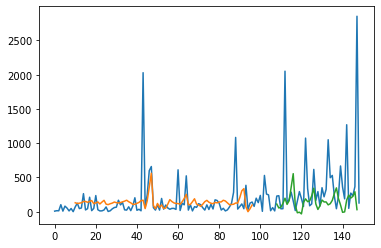

In [165]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()